## Hourly Range Trading

### Thesis 

Look at hourly candles for the 24hrs of the trading day to find out lowest volume hours that are in market hours, i.e. ranging markets in low spread conditions. this would be an ideal timeframe for implementing a scalping algorithm which benefits on these sideways conditions.

In [126]:
"""
Symbol: EURUSD
Start                     2024-04-01 00:10:00
End                       2024-05-31 23:55:00
Duration                     60 days 23:45:00
Exposure Time [%]                   95.389027
Equity Final [$]                  10001.17272
Equity Peak [$]                   10003.84072
Return [%]                           0.011727
Buy & Hold Return [%]                0.515177
Return (Ann.) [%]                     0.06569
Volatility (Ann.) [%]                0.058499
Sharpe Ratio                         1.122935
Sortino Ratio                        1.813411
Calmar Ratio                         2.208916
Max. Drawdown [%]                   -0.029739
Avg. Drawdown [%]                   -0.001399
Max. Drawdown Duration       16 days 09:20:00
Avg. Drawdown Duration        0 days 14:14:00
# Trades                                   41
Win Rate [%]                        46.341463
Best Trade [%]                       1.081212
Worst Trade [%]                          -1.0
Avg. Trade [%]                       0.026706
Max. Trade Duration           4 days 23:35:00
Avg. Trade Duration           1 days 09:19:00

"""

'\nSymbol: EURUSD\nStart                     2024-04-01 00:10:00\nEnd                       2024-05-31 23:55:00\nDuration                     60 days 23:45:00\nExposure Time [%]                   95.389027\nEquity Final [$]                  10001.17272\nEquity Peak [$]                   10003.84072\nReturn [%]                           0.011727\nBuy & Hold Return [%]                0.515177\nReturn (Ann.) [%]                     0.06569\nVolatility (Ann.) [%]                0.058499\nSharpe Ratio                         1.122935\nSortino Ratio                        1.813411\nCalmar Ratio                         2.208916\nMax. Drawdown [%]                   -0.029739\nAvg. Drawdown [%]                   -0.001399\nMax. Drawdown Duration       16 days 09:20:00\nAvg. Drawdown Duration        0 days 14:14:00\n# Trades                                   41\nWin Rate [%]                        46.341463\nBest Trade [%]                       1.081212\nWorst Trade [%]                          

In [127]:
import MetaTrader5 as mt5
import pandas as pd
from backtesting import Backtest, Strategy
import ta
from datetime import datetime
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
# Initialize MetaTrader 5
mt5.initialize()

# Settings
symbols = 'EURUSD'
timeframe = mt5.TIMEFRAME_H1
start_date = datetime(2024, 1, 1)
end_time = datetime.now()


# Function to get data from MetaTrader 5
def get_data(symbol, timeframe, start_date, end_time):
    rates = mt5.copy_rates_range(symbol, timeframe, start_date, end_time)
    df = pd.DataFrame(rates)
    df = df[['time', 'open', 'high', 'low', 'close']]
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

def calculate_range(symbols, timeframe, start_date, end_time):
    data = get_data(symbols, timeframe, start_date, end_time)
    data['range'] = data['high'] - data['low']
    return data

def generate_signal(data):
    # Calculate Bollinger Bands
    data['Upper_BB'] = ta.volatility.bollinger_hband(data['close'], window=20)
    data['Lower_BB'] = ta.volatility.bollinger_lband(data['close'], window=20)
    data['Signals'] = 0
    
    for i in range(1, len(data)):
        # Long signal: when close price is below the lower Bollinger Band
        if (data['close'].iloc[i] < data['Lower_BB'].iloc[i]) and (data['close'].iloc[i-1] >= data['Lower_BB'].iloc[i-1]):
            data.at[data.index[i], 'Signals'] = 1
        # Short signal: when close price is above the upper Bollinger Band
        elif (data['close'].iloc[i] > data['Upper_BB'].iloc[i]) and (data['close'].iloc[i-1] <= data['Upper_BB'].iloc[i-1]):
            data.at[data.index[i], 'Signals'] = -1
        else:
            data.at[data.index[i], 'Signals'] = 0
        
    return data

def SIGNAL(data):
    return data['Signals']


data = calculate_range(symbols, timeframe, start_date, end_time)

data_5min = calculate_range(symbols, mt5.TIMEFRAME_M1, datetime(2024, 5, 26), datetime(2024, 6, 1))
data_5min['hour'] = data_5min.index.hour

data_gen_signal = generate_signal(data_5min)

Displaying a boxplot to show the distribution of the range of the hourly candles, for further dissection 

<Figure size 1200x1600 with 0 Axes>

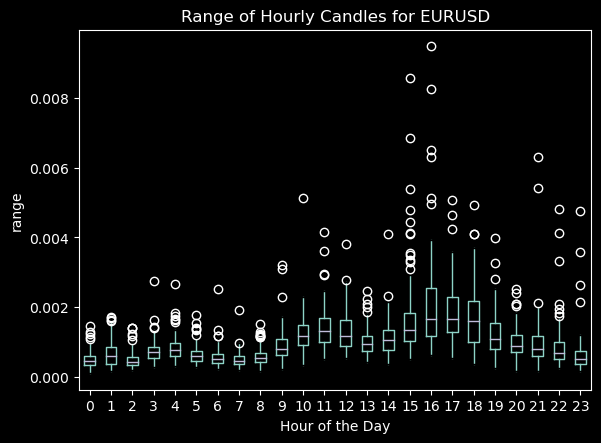

In [129]:

# Extract the hour from the index and group by hour
data['hour'] = data.index.hour

# Create a boxplot
plt.figure(figsize=(12, 16))
data.boxplot(column='range', by='hour', grid=False)
plt.title(f'Range of Hourly Candles for {symbols}')
plt.suptitle('')  # Suppress the automatic 'Boxplot grouped by hour' title
plt.xlabel('Hour of the Day')
plt.ylabel('range')
plt.show()


In [130]:
class hourlyrange(Strategy):
    initsize = 10000.0
    mysize = initsize
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL, self.data.df)
        
    def next(self):
        super().next()
        pip_value = 0.0001
        # Mean reversion vs Trending
        if self.data.hour[-1] == 8 and self.signal1[-1] == 1:
            sl1 = self.data.Close[-1] - (1.5 * pip_value)
            tp1 = self.data.Close[-1] + (4.5 * pip_value)
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        elif self.data.hour[-1] == 8 and self.signal1[-1] == -1:
            sl1 = self.data.Close[-1] + (1.5 * pip_value)
            tp1 = self.data.Close[-1] - (4.5 * pip_value)
            self.sell(sl=sl1, tp=tp1, size=self.mysize)


In [131]:
data_gen_signal.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)

# Conduct backtest
bt = Backtest(data_gen_signal, hourlyrange, cash=10000, exclusive_orders=True, margin=1/100)

# Outputs
output = bt.run()
print(f"Symbol: {symbols}")
print(output)
print('-' * 50)
bt.plot()

c:\Users\User\anaconda3\anaconda_3\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


Symbol: EURUSD
Start                     2024-05-27 00:10:00
End                       2024-05-31 23:00:00
Duration                      4 days 22:50:00
Exposure Time [%]                    4.303797
Equity Final [$]                      10017.0
Equity Peak [$]                       10017.0
Return [%]                               0.17
Buy & Hold Return [%]                0.039643
Return (Ann.) [%]                    6.013748
Volatility (Ann.) [%]                0.065797
Sharpe Ratio                        91.399079
Sortino Ratio                             inf
Calmar Ratio                       128.055731
Max. Drawdown [%]                   -0.046962
Avg. Drawdown [%]                   -0.011798
Max. Drawdown Duration        1 days 00:01:00
Avg. Drawdown Duration        0 days 01:20:00
# Trades                                   20
Win Rate [%]                             40.0
Best Trade [%]                       0.041709
Worst Trade [%]                     -0.013899
Avg. Trade [%]     

Row(id='9874', ...)